In [3]:
import numpy as np
from numpy.random import uniform
import matplotlib.pyplot as plt
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from scipy import integrate
from mpl_toolkits.mplot3d import Axes3D

## SIRV Epidemic Model

#### S = susceptible
#### I = infected
#### R = recovered
#### V = vaccinated

* $\beta$ = number infections per infected

* $\gamma$ = recovery rate

* $\mu$ = recruitment rate = death rate

* $\psi$ = vaccination rate
 
----------------------
----------------------

$
\Large\frac{dS}{dt} = (1 - \psi)\mu N - \frac{\beta I S}{N} - \mu S \\
\Large\frac{dI}{dt} = \beta \cdot I \cdot \frac{S}{N} - \gamma I \\
\Large\frac{dR}{dt} = \gamma I - \omega R
\Large\frac{dV}{dt} = vS - \sigma V\\
$

In [2]:
def sim_SIR(N, I, vday, maxdays, vrate=0.5, gamma=0.2, beta=1.2, sigma=1/100, omega=1/150):
    S = N
    V = 0
    I = I
    R = 0
    S_all = []
    V_all = []
    I_all = []
    R_all = []

    # the model
    for day in range(0, maxdays):
        if day < vday:
            dS = 0.001*N + (omega*R) - (beta * I * (S / N))
            dV = 0
            dI = (beta * I * (S/N) - (gamma * I))
            dR = (gamma*I - omega*R)
        elif day >= vday:
            dS = 0.001*N + (sigma*V + omega*R) - (beta * I * (S / N)) - vrate*S
            dV = (vrate*S - sigma*V)
            dI = (beta * I * (S/N) - (gamma * I))
            dR = (gamma*I - omega*R)

        if (S+dS) < 0: 
            S = 0      
        else: 
            S += dS

        I += dI
        R += dR
        V += dV
        
        S_all.append(S)
        I_all.append(I)
        R_all.append(R)
        V_all.append(V)
    
    return S_all, I_all, R_all, V_all

def plot_SIR(N, I, vday, maxdays, vrate, gamma, beta, sigma, omega):
    S_all, I_all, R_all, V_all = sim_SIR(N, I, vday, maxdays, vrate, gamma, beta, sigma, omega)
    x = range(0, maxdays)
    plt.figure(figsize=[14,4])
    plt.fill_between(x, S_all, color='tab:purple', alpha=0.25, label='Susceptible')
    plt.fill_between(x, V_all, color='tab:green', alpha=0.25, label='Vaccinated')
    plt.fill_between(x, I_all, color='tab:red', alpha=0.25, label='Infected')
    plt.fill_between(x, R_all, color='tab:blue', alpha=0.25, label='Recovered')
    plt.plot(S_all, color='tab:purple', lw=2)
    plt.plot(V_all, '--', color='tab:green', lw=2)
    plt.plot(I_all, color='tab:red', lw=2)
    plt.plot(R_all, color='tab:blue', lw=2)
    plt.xlabel('Days')
    plt.ylabel('Population')

interact(plot_SIR,
         N=widgets.IntSlider(min=100, max=10000000, step=100, value=10000000),
         I=widgets.IntSlider(min=1, max=100, step=1, value=1),
         vday=widgets.IntSlider(step=1, max=1000, value=365),
         maxdays=widgets.IntSlider(min=10, max=5000, step=1, value=500),
         vrate=widgets.FloatSlider(min=0.0, max=1.0, step=0.01, value=0.05),
         gamma=widgets.FloatSlider(min=0.0, max=1.0, step=0.01, value=0.12),
         beta=widgets.FloatSlider(min=0.0, step=0.01, max=2.00, value=0.35),
         sigma=widgets.FloatSlider(min=0.0, max=1.0, step=0.005, value=1/100),
         omega=widgets.FloatSlider(min=0.0, max=1.0, step=0.005, value=1/150))

interactive(children=(IntSlider(value=10000000, description='N', max=10000000, min=100, step=100), IntSlider(v…

<function __main__.plot_SIR(N, I, vday, maxdays, vrate, gamma, beta, sigma, omega)>

## Phase Portrait


In [2]:
def plot_result(beta, gamma, N, angle, N_trajectories=10, t_max=10000):
    def SIR(state, t0, beta=beta, gamma=gamma, N=N, u=1/60):
        """Compute the time-derivative of a Lorentz system."""
        S = state[0]
        I = state[1]
        R = state[2]
        dS = u*N - u*S - (beta * I * (S / N))
        dI = (beta * I * (S/N) - (gamma * I) - u*I)
        dR = (gamma*I - u*R)
        return [dS, dI, dR]

    # initial values
    x0 = []
    for i in range(N_trajectories):
        x0.append([np.random.uniform(100, N), np.random.uniform(0, N/5), 0])

    # solve for the trajectories
    np.random.seed(1)
    t = np.linspace(0, t_max, 2500)
    x_t = np.asarray([integrate.odeint(SIR, x0i, t)
                    for x0i in x0])

    # set up figure & 3D axis for animation
    fig = plt.figure(figsize=[6, 6])
    ax = fig.add_axes([0, 0, 1, 1], projection='3d')
    ax.set_xlabel('Susceptible')
    ax.set_ylabel('Infected')
    ax.set_zlabel('Recovered')
    ax.xaxis.set_pane_color((0.90, 0.95, 1.0, 1.0))
    ax.yaxis.set_pane_color((0.90, 0.95, 1.0, 1.0))
    ax.zaxis.set_pane_color((0.90, 0.95, 1.0, 1.0))
    ax.xaxis._axinfo["grid"]['color'] =  (1,1,1,1)
    ax.yaxis._axinfo["grid"]['color'] =  (1,1,1,1)
    ax.zaxis._axinfo["grid"]['color'] =  (1,1,1,1)
    ax.view_init(30, angle)

    for x0i in x0:
        ax.scatter(x0i[0], x0i[1], x0i[2])

    for trajectory in x_t:
        x = [s[0] for s in trajectory]
        y = [s[1] for s in trajectory]
        z = [s[2] for s in trajectory]
        ax.plot(x, y, z, linewidth=2)

    plt.show()

interact(plot_result,
         N=widgets.IntSlider(min=100, max=10000, step=100, value=1000),
         gamma=widgets.FloatSlider(min=0.0,  step=0.01, max=2.0, value=1/3),
         beta=widgets.FloatSlider(min=0.0, step=0.01, max=2.0, value=0.35),
         angle=widgets.IntSlider(min=0, value=150, step=10, max=360),
         t_max=widgets.IntSlider(min=0, step=1, max=1000, value=0),
         N_trajectories=widgets.IntSlider(min=5, step=1, max=30, value=10))

interactive(children=(FloatSlider(value=0.35, description='beta', max=2.0, step=0.01), FloatSlider(value=0.333…

<function __main__.plot_result(beta, gamma, N, angle, N_trajectories=10, t_max=10000)>

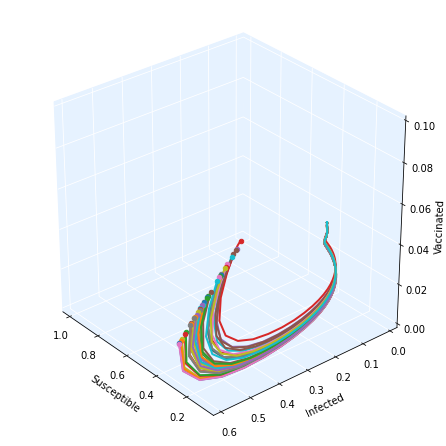

In [10]:
beta = 0.5
u = 1/50
gamma = 1/10
psi = 0.05
N = 1000
t_max = 5000
angle = 140
N_traj = 40

def SIR(t, state):
        S, I, R, V = state
        dS = (1-psi)*u*N - (beta*I*S)/N - u*S
        dI = (beta*I*S)/N - (gamma+u)*I
        dR = gamma*I - u*R
        dV = psi*u*N - u*V
        return dS, dI, dR, dV

# initial values
Y0 = []
for traj in range(N_traj):
    s_init = uniform(0.5, 1.0)
    Y0.append(((s_init)*N, (1-s_init)*N, 0, 0))

# solve for the trajectories
s = []
i = []
v = []
for y0 in Y0:
    sol = integrate.solve_ivp(SIR, t_span=(0, t_max), y0=y0, t_eval=np.linspace(0, t_max, 2500))
    s_, i_, r_, v_ = sol.y
    s.append([value/N for value in s_])
    i.append([value/N for value in i_])
    v.append([value/N for value in v_])

# setup fig
fig = plt.figure(figsize=[6, 6])
ax = fig.add_axes([0, 0, 1, 1], projection='3d')
ax.set_xlabel('Susceptible')
ax.set_ylabel('Infected')
ax.set_zlabel('Vaccinated')
ax.xaxis.set_pane_color((0.90, 0.95, 1.0, 1.0))
ax.yaxis.set_pane_color((0.90, 0.95, 1.0, 1.0))
ax.zaxis.set_pane_color((0.90, 0.95, 1.0, 1.0))
ax.xaxis._axinfo["grid"]['color'] =  (1,1,1,1)
ax.yaxis._axinfo["grid"]['color'] =  (1,1,1,1)
ax.zaxis._axinfo["grid"]['color'] =  (1,1,1,1)
ax.view_init(30, angle)
ax.set_zlim3d(0,0.1)

for traj in range(N_traj):
    ax.plot(s[traj], i[traj], v[traj], linewidth=2)

for traj in range(N_traj):
    ax.scatter(s[traj][0], i[traj][0], v[traj][0])

plt.savefig('b_0.1.png', dpi=200)


Text(0, 0.5, 'susceptible')

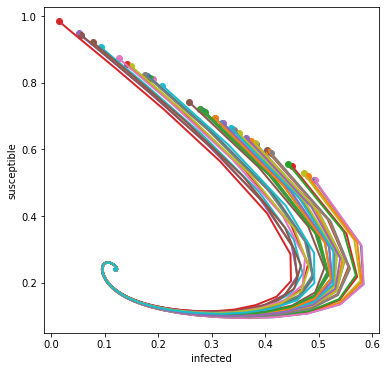

In [11]:
fig, ax = plt.subplots(figsize=[6,6])

for traj in range(N_traj):
    ax.plot(i[traj], s[traj], linewidth=2)

for traj in range(N_traj):
    ax.scatter(i[traj][0], s[traj][0])

ax.set_xlabel('infected')
ax.set_ylabel('susceptible')